In [33]:
import numpy as np
from numpy import log2
from scipy import signal, fft
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [34]:
colors = {"input" : "navy",
         "noise" : "gray",
         "clean" : "royalblue",
         "pyfilter" : "indianred",
         "fpgafilter" : "darkred"}

# Preliminary plots

### Taps

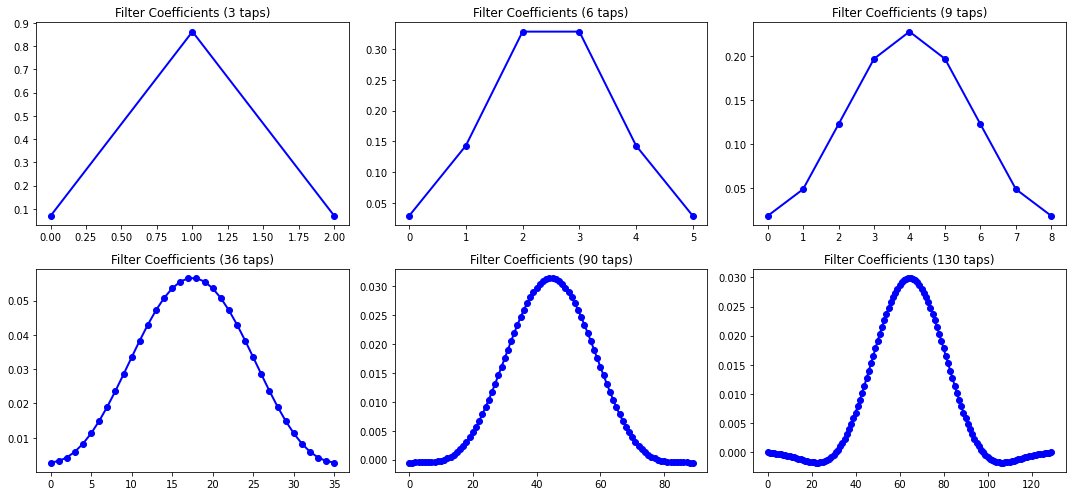

In [35]:
# FIR filter coefficients - changing nr. of taps
sample_rate = 200
nT = [3,6,9,36,90,130]
f = 3

T = []
for i in nT:
    taps = signal.firwin(i, f, fs=sample_rate)
    T.append(taps)

# plots 
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(15,7))

ax1.plot(T[0], 'bo-', linewidth=2)
ax1.set_title('Filter Coefficients (3 taps)')
ax2.plot(T[1], 'bo-', linewidth=2)
ax2.set_title('Filter Coefficients (6 taps)')
ax3.plot(T[2], 'bo-', linewidth=2)
ax3.set_title('Filter Coefficients (9 taps)')
ax4.plot(T[3], 'bo-', linewidth=2)
ax4.set_title('Filter Coefficients (36 taps)')
ax5.plot(T[4], 'bo-', linewidth=2)
ax5.set_title('Filter Coefficients (90 taps)')
ax6.plot(T[5], 'bo-', linewidth=2)
ax6.set_title('Filter Coefficients (130 taps)')

plt.tight_layout()
plt.savefig("Images/change_nT.pdf")
plt.show()
    

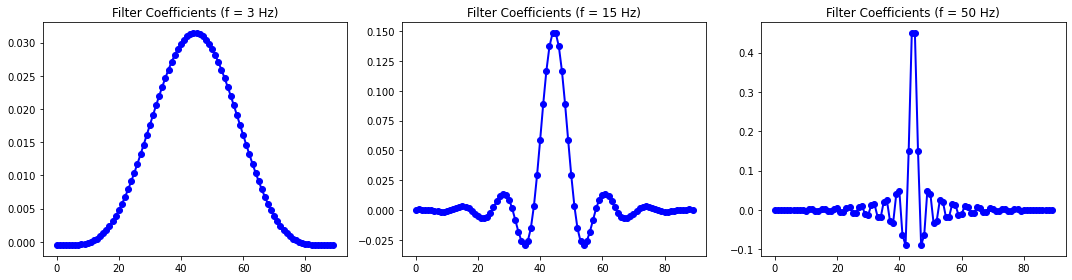

In [36]:
# FIR filter coefficients - changing cut-off freq
sample_rate = 200
nT = 90
f = [3, 15, 50]

T = []
for i in f:
    taps = signal.firwin(nT, i, fs=sample_rate)
    T.append(taps)

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

ax1.plot(T[0], 'bo-', linewidth=2)
ax1.set_title(f'Filter Coefficients (f = {f[0]} Hz)')
ax2.plot(T[1], 'bo-', linewidth=2)
ax2.set_title(f'Filter Coefficients (f = {f[1]} Hz)')
ax3.plot(T[2], 'bo-', linewidth=2)
ax3.set_title(f'Filter Coefficients (f = {f[2]} Hz)')

plt.tight_layout()
plt.savefig("Images/change_f.pdf")
plt.show()

### Freq response

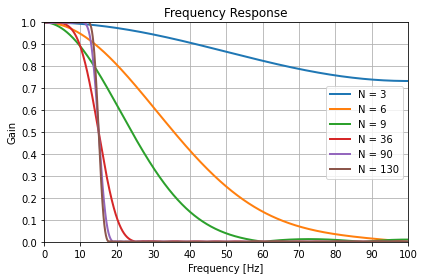

In [37]:
# Plot the magnitude response of the filter - changing nr. of taps
sample_rate = 200
nyq_rate = sample_rate / 2

nT = [3,6,9,36,90,130]   #9 and 12
f = 15

for i in nT:
    taps = signal.firwin(i, f, fs=sample_rate)              ## specifying "fs=" it interprets f in the same units of the sample rate
    w, h = signal.freqz(taps, worN=8000, fs=sample_rate)    ## specifying "fs=" it interprets f in the same units of the sample rate
    
    plt.plot(w, np.absolute(h),linewidth=2, label='N = %d'%i)  ## evidence of the scale!! The x axis has changed
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("Images/gaincurves_vs_nT.pdf")
plt.show()

Gain on clean signal:


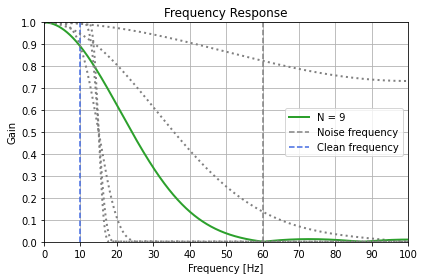

In [38]:
# Plot the magnitude response of the filter - changing nr. of taps
sample_rate = 200
nyq_rate = sample_rate / 2

nT = [3,6,9,36,90,130]   #9 and 12
f = 15

print("Gain on clean signal:")
for i in nT:
    taps = signal.firwin(i, f, fs=sample_rate)
    w, h = signal.freqz(taps, worN=8000, fs=sample_rate)
#    print(f"Gain for {i} taps : {np.abs(h[np.argwhere((w/np.pi)*nyq_rate == 10)])[0,0]:.4f}")
    if i == 9: plt.plot(w, np.absolute(h),linewidth=2, label='N = %d'%i, color="tab:green")
    else:      plt.plot(w, np.absolute(h),linewidth=2, linestyle=':', color='grey')
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlim(0,100)
plt.ylim(0,1)
plt.vlines(60, 0, 1, colors=colors["noise"], linestyles='dashed', label='Noise frequency')
plt.vlines(10, 0, 1, colors=colors["clean"], linestyles='dashed', label='Clean frequency')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("Images/gain_and_freq.pdf")
plt.show()

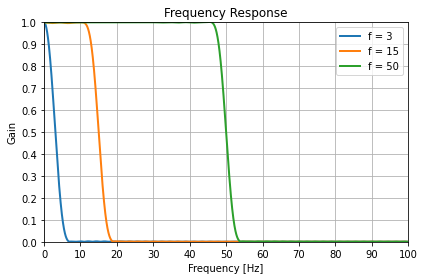

In [39]:
# Plot the magnitude response of the filter - changing cut-off freq
nT = 90
f = [3, 15, 50]

sample_rate = 200
nyq_rate = sample_rate / 2

for i in f:
    taps = signal.firwin(nT, i, fs=sample_rate)
    w, h = signal.freqz(taps, worN=8000, fs=sample_rate)
    
    plt.plot(w, np.absolute(h),linewidth=2, label='f = %d'%i)
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("Images/gaincurve_vs_f.pdf")
plt.show()

In [40]:
def computeQ(y):
    M = np.abs(y).max()
    Q = log2(127) - log2(M)
    return Q

def double_to_signed(a, Q):
    int_a = np.round(a*2**Q)
    signed = np.where(int_a >= 0, int_a, int_a + 256).astype(int)
    return signed
    
def signed_to_double(a,Q):
    signed = np.where(a >= 128, a-256, a)
    double_a = signed*2**(-Q)
    return double_a

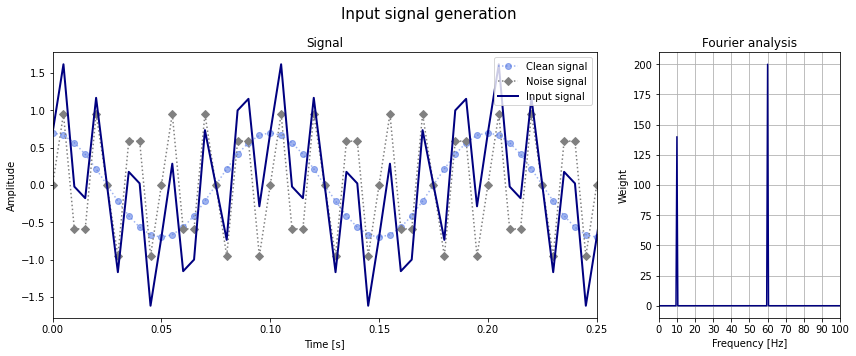

In [41]:
sample_rate = 200
nsamples = 400
freq_camp = sample_rate/nsamples
t = np.arange(nsamples) / sample_rate
clean = 0.7*np.cos(2*np.pi*10*t)  # 10/400 = 0.025
noise = np.sin(2*np.pi*60*t)  # 60/400 = 0.15 > 0.1
input_signal = clean + noise

fig = plt.figure(figsize=(12,5))
fig.suptitle("Input signal generation", fontsize=15)
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])
ax0, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

ax0.plot(t, clean, ":o", color=colors["clean"], label='Clean signal', alpha=0.5)
ax0.plot(t, noise, ":D", color=colors["noise"], label='Noise signal')
ax0.plot(t,input_signal, linewidth=2, label='Input signal', color=colors["input"])
ax0.set_xlim(0,0.25)
ax0.legend()
ax0.set_xlabel("Time [s]")
ax0.set_ylabel("Amplitude")
ax0.set_title("Signal")

fft_input_signal = np.abs(fft.fft(input_signal))
input_freq = fft.fftfreq(input_signal.shape[0], 1 / sample_rate)
mask = input_freq > 0
input_freq = input_freq[mask]
fft_input_signal = fft_input_signal[mask]
ax1.plot(input_freq, fft_input_signal, color=colors["input"])
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Weight")
ax1.set_title("Fourier analysis")
ax1.set_xticks(np.linspace(0, 100, 11))
ax1.set_xlim(0,100)
ax1.grid(True)

plt.tight_layout()
plt.savefig("Images/input_generation.pdf")
plt.show()

In [42]:
numtaps = 9
f = 15             #cut-off freq
taps= signal.firwin(numtaps, f, fs=sample_rate)

print('coeff_1 = ', taps)

coeff_1 =  [0.01015441 0.03774083 0.11661103 0.20970858 0.2515703  0.20970858
 0.11661103 0.03774083 0.01015441]


In [43]:
## taps in binary
Q = computeQ(taps)
prova = np.array(taps)
prova = double_to_signed(prova, Q)
print("Taps in binary code:", [bin(i) for i in prova])

Taps in binary code: ['0b101', '0b10011', '0b111011', '0b1101010', '0b1111111', '0b1101010', '0b111011', '0b10011', '0b101']


In [44]:
MBNO = bin(255 * np.sum(prova))
print(f"The Maximum Binary Number Obtainable is: {MBNO}")
print(f"The fir filter output must select the bins: {len(MBNO)-2-1} downto {len(MBNO)-2-8}")

The Maximum Binary Number Obtainable is: 0b11111011100000111
The fir filter output must select the bins: 16 downto 9


In [45]:
w, h = signal.freqz(taps/normalization_taps, worN=8000, fs=sample_rate)

gain_on_clean = np.abs(h[np.argwhere(w == 10)])[0,0]

print("Gain on clean signal:", gain_on_clean)

Gain on clean signal: 0.889783115404638


In [46]:
delay = 0.5 * (numtaps-1) / sample_rate

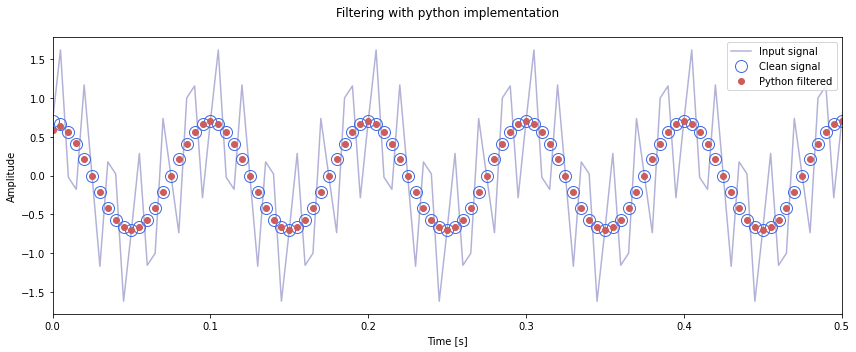

In [47]:
pyfiltered = signal.lfilter(taps, 1, input_signal)

pyfiltered = pyfiltered / gain_on_clean

fig = plt.figure(figsize=(12,5))
plt.plot(t, input_signal, label="Input signal", color=colors["input"], alpha=0.3)
plt.plot(t, clean, 'o', markersize=12, fillstyle="none", label="Clean signal", color=colors["clean"])
plt.plot(t-delay, pyfiltered, "o", label="Python filtered", color=colors["pyfilter"])
plt.legend()
plt.title("Filtering with python implementation\n")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0,0.5)

plt.tight_layout()
plt.savefig("Images/python_filtered.pdf")
plt.show()

## Comments on the whole thing

I've made several modifications, required for the different normalization of the taps. Here I list the logical order of the things.
1. We start from a signal.
2. We select the number of taps and the cut-off frequency.
3. We compute the `normalization_taps` which is the factor that makes the largest tap as large as the maximum amplitude of the signal.

At this point, it is quite mandatory to have a signal which offset is 0. The more symmetric the signal is wrt the offset, the better is the result.

4. At this point, we can compute the Q only on the signal (or only on the taps, since now they're equally normalized).
5. We can convert the taps from double to signed, and then to binary in order to properly set the coefficients in the FPGA.

Now the largest tap will always be "01111111" (highest positive value), due to the normalization factor. This means that the binary values of the taps (after conversion) will depend only on the number of taps and the cut-off frequency.

6. We can also compute the maximum value obtainable inside the FPGA in the variable `adder` (named here `MBNO`) and set the corresponding most significant bits into the VHDL code when we produce the final processed data.

Now this value is fixed, indipendently from the input signal. In fact, given the normalizations we have, the maximum amplitude of the signal will always be 255 (after conversion to signed of course), so we can estimate the maximum value obtainable as $255 *$ the sum of the taps converted into signed (which again doesn't depend on the specific signal).

7. We now feed the python-FIR with the input signal, but we must consider that now the taps are not normalized to 1, so the total gain of the pyFIR-filter will be `normalization_taps`. For this reason, we must rescale the amplitude of the converted signal, and delay the signal with the correct value.
8. Now we convert (and split if required) the input signal to feed the FPGA.
9. We process the input signal through the FPGA.
10. We collect the output data in a vector, and renormalizing the signal we will have a perfect matching between the pyFIR filter and the FPGA one.

The reason for this last renormalization is the following. When we compute the variable `MBNO`, not necessarily it is a multiple of 2. IF this is not the case, we still have to take enough bits to represent all the numbers inside the FPGA. Let's consider $N$ the number of significant bits we must keep, then $2^N$ is the greatest . All the numbers between `MNBO` and $2^N$ won't be represented, which means that the gain in the FPGA will be `MBNO` and not $2^N$. In order to have the correct output is thus necessary to renormalize with a factor $\frac{MBNO}{2^N}$

0.9824752807617188


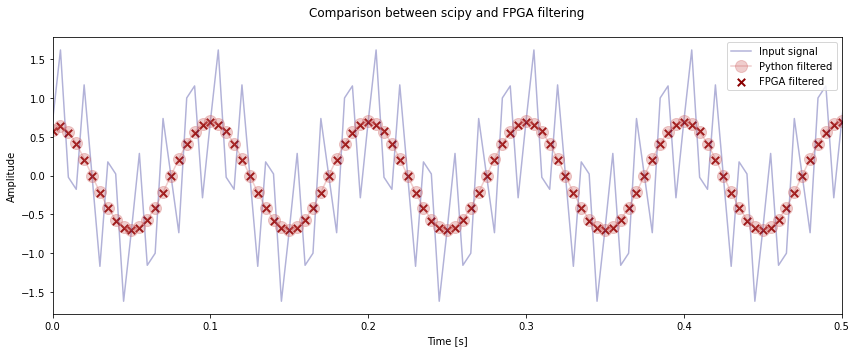

In [52]:
Q = computeQ(input_signal)

fpga_gain = int(MBNO, 2) / 2**(len(MBNO)-2)
print(fpga_gain)
#fpga_gain = 1

filtered_signal = np.array([], dtype=int)
for i in range(16):
    filename = "filtered_signal"+str(i)+".txt"
    filtered_signal = np.append(filtered_signal, np.loadtxt(filename, dtype=int))

filtered_signal = signed_to_double(filtered_signal, Q) / fpga_gain / gain_on_clean

fig = plt.figure(figsize=(12,5))
plt.plot(t, input_signal, color=colors["input"], label='Input signal', alpha=0.3)
plt.plot(t-delay, pyfiltered, marker='o', markersize=12, color=colors["pyfilter"], label="Python filtered", alpha=0.3)
plt.scatter(t-delay, filtered_signal, linewidth=2, marker='x', s=55, color=colors["fpgafilter"], label="FPGA filtered")
plt.legend()
plt.title("Comparison between scipy and FPGA filtering\n")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0,0.5)

plt.tight_layout()
plt.savefig("Images/comparison.pdf")
plt.show()

$$ \varepsilon_\text{trunc} \le \max_i \lvert x_i\rvert \cdot \frac{2^{A-7}-1}{2^{A}-1}$$

Where $A$ is the index of the most significant bit which is kept during the truncation, the $-1$ is needed to shift right and not consider the sign bit.

In [49]:
most_significant_value_bit = len(MBNO)-2-1   ## -2 for the "0b" chars, -1 for the index
fpga_error = np.abs(input_signal).max() * (2**(most_significant_value_bit-7) - 1)/ (2**most_significant_value_bit - 1)
fpga_error

0.012606741370345932

In [50]:
Q_error = 0.5 * np.abs(input_signal).max() / (2**7 - 1)
Q_error

0.006365338888589771

(2, 400)


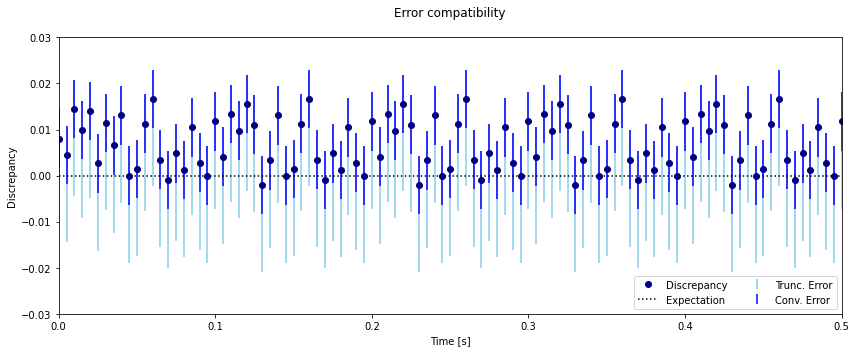

In [51]:
trunc_errors = np.repeat([[Q_error+fpga_error, Q_error]], t.shape[0], axis=0).T
conv_errors = np.full(t.shape[0], Q_error)

print(trunc_errors.shape)

plt.figure(figsize=(12,5))
plt.title("Error compatibility\n")
plt.xlabel("Time [s]")
plt.ylabel("Discrepancy")
plt.errorbar(t, pyfiltered-filtered_signal, yerr=trunc_errors, linestyle='', color="skyblue", label="Trunc. Error")
plt.errorbar(t, pyfiltered-filtered_signal, yerr=conv_errors, linestyle='', color="blue", label="Conv. Error")
plt.plot(t, pyfiltered-filtered_signal, 'o', color="navy", label="Discrepancy")
plt.hlines(0, 0, 2, color="black", linestyle=':', label="Expectation")
plt.xlim(0, 0.5)
plt.ylim(-0.03, 0.03)
plt.legend(loc="lower right", ncol=2)
plt.tight_layout()
plt.savefig("Images/error_estimation.pdf")
plt.show()

In [6]:
"""def computeQ(y,taps):
    M = max(max(np.abs(taps)),max(np.abs(y)))
    Q = log2(127) - log2(M)
    return Q

def double_to_signed(a, Q): #only one element each time
    int_a = int(a*2**Q)
    signed =0
    if int_a >= 0: signed = int_a
    if int_a <0: signed= int_a + 256
    return int(signed)

def signed_to_double(a,Q):
    signed=0
    if a>= 128 : signed = a-256
    if a<128 : signed = a

    double_a = signed*2**(-Q)
    return double_a
"""

'def computeQ(y,taps):\n    M = max(max(np.abs(taps)),max(np.abs(y)))\n    Q = log2(127) - log2(M)\n    return Q\n\ndef double_to_signed(a, Q): #only one element each time\n    int_a = int(a*2**Q)\n    signed =0\n    if int_a >= 0: signed = int_a\n    if int_a <0: signed= int_a + 256\n    return int(signed)\n\ndef signed_to_double(a,Q):\n    signed=0\n    if a>= 128 : signed = a-256\n    if a<128 : signed = a\n\n    double_a = signed*2**(-Q)\n    return double_a\n'

In [7]:
y = ys1 + ys2
Q = computeQ(y, taps)
#signed = double_to_signed(y,Q)
#double = signed_to_double(signed,Q)
"""
plt.figure(figsize=(15,6))
plt.plot(t,y, 'r--o')
plt.plot(t,double, 'bo')
plt.xlim(1,1.5)
plt.show()"""

"\nplt.figure(figsize=(15,6))\nplt.plot(t,y, 'r--o')\nplt.plot(t,double, 'bo')\nplt.xlim(1,1.5)\nplt.show()"

In [8]:
Q = computeQ(y, taps)
#integer_taps = double_to_signed(taps, Q)
#print([bin(i) for i in integer_taps])

In [9]:
"""Q = computeQ(y, taps)
y_signal_singed=[int(double_to_signed(i,Q)) for i in y]

#print(y_signal_singed[:25])

y0=y_signal_singed[:25]
y1=y_signal_singed[25:50]
y2=y_signal_singed[50:75]
y3=y_signal_singed[75:100]
y4=y_signal_singed[100:125]
y5=y_signal_singed[125:150]
y6=y_signal_singed[150:175]
y7=y_signal_singed[175:200]
y8=y_signal_singed[200:225]
y9=y_signal_singed[225:250]
y10=y_signal_singed[250:275]
y11=y_signal_singed[275:300]
y12=y_signal_singed[300:325]
y13=y_signal_singed[325:350]
y14=y_signal_singed[350:375]
y15=y_signal_singed[375:400]

ypsi=[y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15]

#for i in range(16):
 #   np.savetxt("signal{}.txt".format(i), ypsi[i],fmt='%1u')"""

'Q = computeQ(y, taps)\ny_signal_singed=[int(double_to_signed(i,Q)) for i in y]\n\n#print(y_signal_singed[:25])\n\ny0=y_signal_singed[:25]\ny1=y_signal_singed[25:50]\ny2=y_signal_singed[50:75]\ny3=y_signal_singed[75:100]\ny4=y_signal_singed[100:125]\ny5=y_signal_singed[125:150]\ny6=y_signal_singed[150:175]\ny7=y_signal_singed[175:200]\ny8=y_signal_singed[200:225]\ny9=y_signal_singed[225:250]\ny10=y_signal_singed[250:275]\ny11=y_signal_singed[275:300]\ny12=y_signal_singed[300:325]\ny13=y_signal_singed[325:350]\ny14=y_signal_singed[350:375]\ny15=y_signal_singed[375:400]\n\nypsi=[y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15]\n\n#for i in range(16):\n #   np.savetxt("signal{}.txt".format(i), ypsi[i],fmt=\'%1u\')'